# Pre-trained CNN for behaviours detection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports and constants

In [ ]:
import random
import tensorflow as tf
from keras import Sequential
from keras.layers import (
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
    Embedding,
    GRU,
    Bidirectional,
    RepeatVector,
    TimeDistributed,
)
from keras.losses import SparseCategoricalCrossentropy, MeanSquaredError
from keras.layers import Conv1D, MaxPool1D, Conv2D, MaxPool2D
from keras.optimizers import Adam, SGD
from os import listdir
from os.path import isfile, join

import os

print(tf.__version__)

2.14.0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import recall_score, confusion_matrix, ConfusionMatrixDisplay

import scipy.stats as stats
import sqlite3
import gc

In [ ]:
training_device: str = "cpu"

if str.lower(training_device) == "cpu":
    tf.config.set_visible_devices(
        devices=[],
        device_type="GPU",
    )
else:
    physical_devices = tf.config.experimental.list_physical_devices("GPU")
    assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
    config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Data pre-processing

### Load the Dataset

In [ ]:
def load_data_sqlite() -> pd.DataFrame:
    connection: sqlite3.Connection = sqlite3.connect(
        database="drive/MyDrive/Ellinbank/video_observation/data/ellinbank_cow-observation_labeled-data.db"
    )
    cursor: sqlite3.Cursor = connection.cursor()

    DATABASE_NAME: str = "LebeledDataTable"

    query: str = """
    select distinct serial_number
    from {}
    """.format(
        DATABASE_NAME
    )

    response: sqlite3.Cursor = cursor.execute(query)
    file_names: list = list(response)
    file_names = [file[0] for file in file_names]

    dataframes: list = []
    for file in file_names:
        query: str = """
            select *
            from {}
            where serial_number = '{}'
        """.format(
            DATABASE_NAME,
            file,
        )
        df: pd.DataFrame = pd.read_sql_query(
            sql=query,
            con=connection,
        )
        dataframes.append(df)
        # break

    dataframe: pd.DataFrame = pd.concat(dataframes)
    return dataframe

In [ ]:
notebook_mode: str = "deploying"
if notebook_mode == "developing":
    full_data: pd.DataFrame = pd.read_csv("../../../data/ellinbank_cow-data_small.csv")
else:
    !cp drive/MyDrive/Ellinbank/video_observation/custom_train_test_loop/k-fold_cross-validation/custom_model.py .
    !cp drive/MyDrive/Ellinbank/video_observation/custom_train_test_loop/k-fold_cross-validation/inference.py .
    !cp drive/MyDrive/Ellinbank/video_observation/custom_train_test_loop/k-fold_cross-validation/utils.py .
    full_data: pd.DataFrame = load_data_sqlite()

In [ ]:
all_cows: list[str] = full_data["nickname"].unique()
all_cows

array(['COW3', 'COW8', 'COW11', 'COW17', 'COW19'], dtype=object)

### Removing `\n` values and lowercase all entries

In [ ]:
full_data.replace(
    to_replace="\n",
    value="",
    regex=True,
    inplace=True,
)
full_data["Behaviour"] = full_data["Behaviour"].str.lower()

### Removing empty behaviours

In [ ]:
full_data = full_data.drop(
    full_data[full_data["Behaviour"] == ""].index,
    inplace=False,
)
behaviour_col_values: np.ndarray = full_data["Behaviour"].unique()
print(behaviour_col_values)
print((full_data["Behaviour"].value_counts()))

['g' 'w' 'o' 'i' 'r' 'd' 'u']
g    2422530
o    1012800
r     869580
i     863940
u      83070
w      56850
d      11130
Name: Behaviour, dtype: int64


### Check for duplicated rows and null values

In [ ]:
duplicated_rows: pd.Series = full_data.duplicated()
duplicated_rows = duplicated_rows[duplicated_rows == True]
print("{} rows duplicated".format(duplicated_rows.shape))

full_data.drop_duplicates(inplace=True)

print(full_data.isnull().sum())
print(full_data.isna().sum())

(0,) rows duplicated
serial_number          0
nickname               0
animalID               0
sample_rate            0
timestamps             0
Behaviour              0
acc_axis1              0
acc_axis2              0
acc_axis3              0
acc_mag                0
lpf_axis1              0
lpf_axis2              0
lpf_axis3              0
lpf_mag                0
hpf_axis1              0
hpf_axis2              0
hpf_axis3              0
hpf_mag                0
spd_axis1              0
spd_axis2              0
spd_axis3              0
spd_mag                0
spd_axis1_denoised     0
spd_axis2_denoised     0
spd_axis3_denoised     0
spd_mag_denoised       0
dis_axis1              0
dis_axis2              0
dis_axis3              0
dis_mag                0
dis_axis1_denoised     0
dis_axis2_denoised     0
dis_axis3_denoised     0
dis_mag_denoised       0
tilt_axis1             0
tilt_axis2             0
tilt_axis3             0
tilt_axis1_denoised    0
tilt_axis2_denoised    0
tilt

In [ ]:
full_data.head(1)

,serial_number,nickname,animalID,sample_rate,timestamps,Behaviour,acc_axis1,acc_axis2,acc_axis3,acc_mag,...,dis_axis1_denoised,dis_axis2_denoised,dis_axis3_denoised,dis_mag_denoised,tilt_axis1,tilt_axis2,tilt_axis3,tilt_axis1_denoised,tilt_axis2_denoised,tilt_axis3_denoised
0,COW3_4_thur_final,COW3,3.0,30.0,2023-04-27 09:11:42.000000,g,-0.703,-0.539,0.227,0.914472,...,-10.99752,15.326401,-2.054346,18.975362,-60.483006,-24.392151,74.414919,-59.035276,-27.707135,77.272273


### Sort data based on date
This ensure that actvities are read in a consecutive order and reseting the index of readings (rows).

In [ ]:
full_data.sort_values(
    by=["timestamps"],
    ascending=True,
    inplace=True,
)

full_data = full_data.reset_index(drop=True)

### Convert numerical values (input data) to float type

In [ ]:
full_data.iloc[:, 6:] = full_data.iloc[:, 6:].astype("float")
# train_df: pd.DataFrame = full_data.copy()

gc.collect()

0

['d' 'g' 'i' 'o' 'r' 'u' 'w']
[  11130 2422530  863940 1012800  869580   83070   56850]


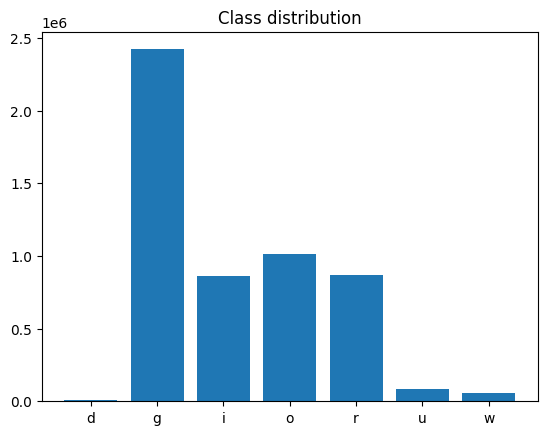

In [ ]:
# Class distribution, will use later but should use seaborn to show labels on columns.
existing_labels: np.ndarray = full_data["Behaviour"].to_numpy()

existing_types, counts = np.unique(
    existing_labels,
    return_counts=True,
)
print(existing_types)
print(counts)

plt.title("Class distribution")
plt.bar(existing_types, counts)
plt.show()

### Handle minor classes
Classes with smaller number of records will be either merged with another class or be removed completely.

In [ ]:
from utils import handle_minor_classes


# full_data = handle_minor_classes(
#     data=full_data,
#     minor_classes=["u"],
#     type="remove",
# )
full_data = handle_minor_classes(
    data=full_data,
    minor_classes=["d", "w", "u"],
    type="merge",
)
gc.collect()

3476

['g' 'i' 'o' 'r']
[2422530  863940 1163850  869580]


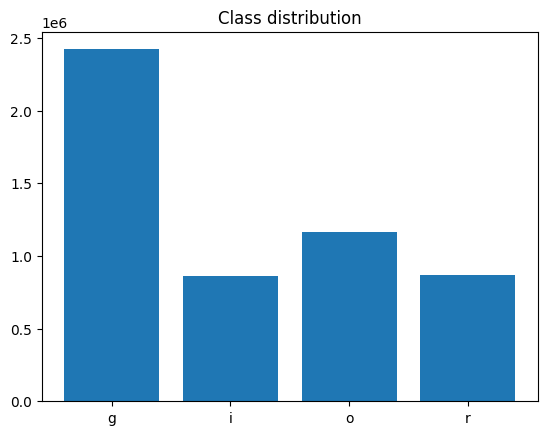

In [ ]:
# Class distribution after dropping/merging minor classes.
existing_labels: np.ndarray = full_data["Behaviour"].to_numpy()

existing_types, counts = np.unique(
    existing_labels,
    return_counts=True,
)
print(existing_types)
print(counts)

plt.title("Class distribution")
plt.bar(existing_types, counts)
plt.show()

['g' 'i' 'o' 'r']
[250650 282780 462630  45300]


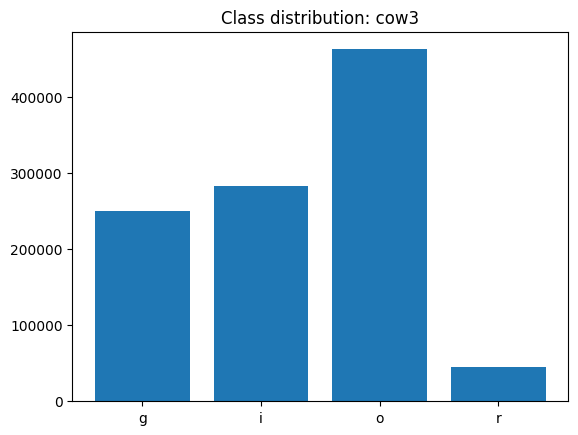

['g' 'i' 'o' 'r']
[239640 121470 520980 275520]


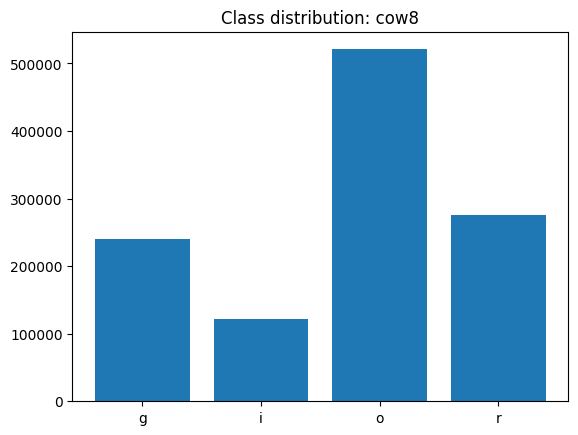

['g' 'i' 'o' 'r']
[591540  23220  30120  39270]


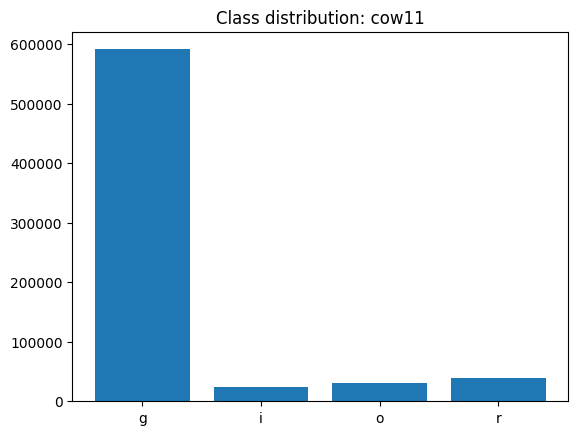

['g' 'i' 'o' 'r']
[658200 254340  82470 223380]


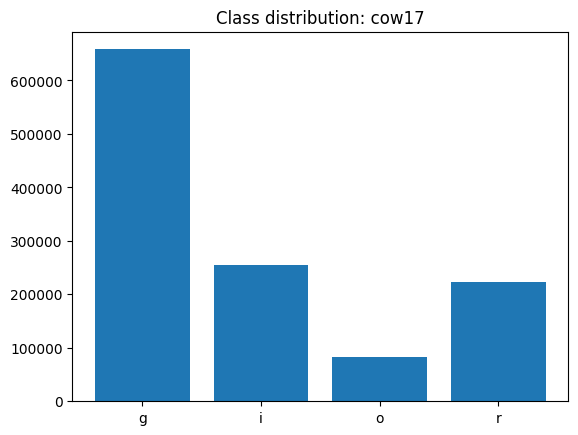

['g' 'i' 'o' 'r']
[682500 182130  67650 286110]


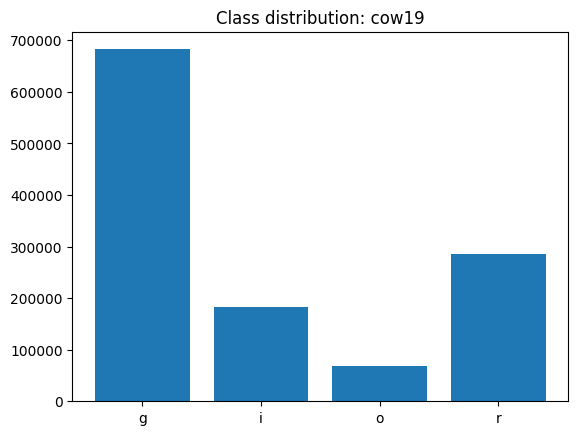

In [ ]:
for cow in all_cows:
    current_cow: pd.DataFrame = full_data.loc[full_data["nickname"] == cow]

    cow_labels: np.ndarray = current_cow["Behaviour"].to_numpy()

    cow_behaviours, counts = np.unique(
        cow_labels,
        return_counts=True,
    )
    print(cow_behaviours)
    print(counts)

    plt.title("Class distribution: {}".format(cow.lower()))
    plt.bar(cow_behaviours, counts)
    plt.show()

### Encode classes using numerical values.

In [ ]:
label = LabelEncoder()
full_data["label"] = label.fit_transform(full_data["Behaviour"])
# unique_labels: np.ndarray = (
#     full_data.groupby(["Behaviour", "label"])
#     .size()
#     .reset_index()["Behaviour"]
#     .to_numpy()
# )


unique_labels: np.ndarray = full_data["label"].unique()
unique_labels.sort()

print(unique_labels)

[0 1 2 3]


### Split cows data into folds for k-fold cross validation.
This process will also remove unnecessary columns and keep only data that will be used for inference.

In [ ]:
folds: dict[str, pd.DataFrame] = {}
columns: list = full_data.columns[6:]

for cow in all_cows:
    # For each unique cow, assign its data into a separate dataframe and
    # remove unnecessary columns.
    folds[cow] = full_data.loc[full_data["nickname"] == cow]
    folds[cow] = folds[cow][columns]

# TODO: Remove data of Cow 11 as it has insufficient amount of data for cross validation.
# folds.pop("COW11")
# TODO: Remember to delete the full_data dataframe to avoid overflow error.
del full_data
gc.collect()

9250

In [ ]:
for c in folds.keys():
    print(c)

COW3
COW8
COW11
COW17
COW19


### Standardize data.

In [ ]:
from utils import standardize_dataframe

for cow in folds.keys():
    standardized_dataframes: pd.DataFrame = standardize_dataframe(
        data=folds[cow],
        std_cols=columns[:-1],
    )
    folds[cow] = standardized_dataframes

gc.collect()

0

In [ ]:
folds["COW3"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041360 entries, 0 to 1041359
Data columns (total 35 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   acc_axis1            1041360 non-null  float64
 1   acc_axis2            1041360 non-null  float64
 2   acc_axis3            1041360 non-null  float64
 3   acc_mag              1041360 non-null  float64
 4   lpf_axis1            1041360 non-null  float64
 5   lpf_axis2            1041360 non-null  float64
 6   lpf_axis3            1041360 non-null  float64
 7   lpf_mag              1041360 non-null  float64
 8   hpf_axis1            1041360 non-null  float64
 9   hpf_axis2            1041360 non-null  float64
 10  hpf_axis3            1041360 non-null  float64
 11  hpf_mag              1041360 non-null  float64
 12  spd_axis1            1041360 non-null  float64
 13  spd_axis2            1041360 non-null  float64
 14  spd_axis3            1041360 non-null  float64
 15

['COW3', 'COW8', 'COW11', 'COW17', 'COW19']
[1041360, 1157610, 684150, 1218390, 1218390]


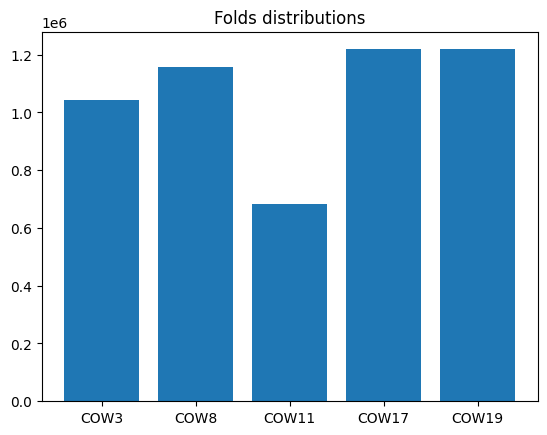

In [ ]:
selected_cows: list[str] = list(folds.keys())
no_of_readings_per_cow: list[int] = [len(folds[c]) for c in selected_cows]

print(selected_cows)
print(no_of_readings_per_cow)

plt.title("Folds distributions")
plt.bar(selected_cows, no_of_readings_per_cow)
plt.show()

## Train-test setup.

### Hyper-parameters

In [ ]:
window_size: int = 600  # 300: 10 seconds
window_per_epoch: int = 200
epoch: int = 150
batch_size: int = 64
# random.seed(715) # 715 looks good.
random.seed(785)  # 785 makes "other" looks bad, otherwise is good.

### Output folder
Output files will be stored in the same folder named `out`.

In [ ]:
import os

# Check if the folder is already exists.
if os.path.isdir("./out"):
    pass
else:
    os.mkdir("./out/")
    for c in all_cows:
        os.mkdir("./out/{}/".format(c.lower()))

## Train and validate the model.

### Train-test loop with k-fold cross validation.
Each fold will be selected as the validation set and an entire train-test loop will be run using that setup. After each run, metrics are collected and the confusion matrix will be plotted. This will be repeated until all the folds are used.

  0%|          | 0/150 [00:00<?, ?it/s]

64/64 [==============================] - 4s 58ms/step
Testing accuracy: 0.9880468249320984


656

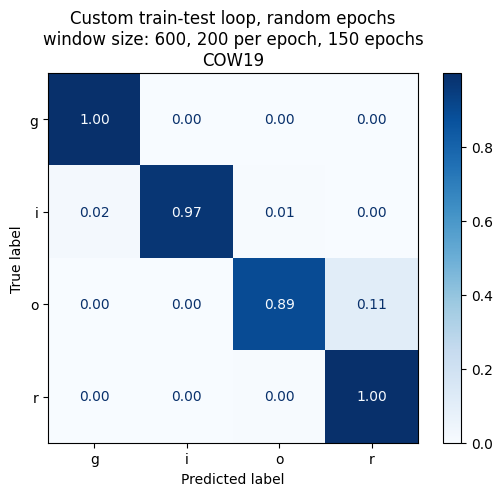

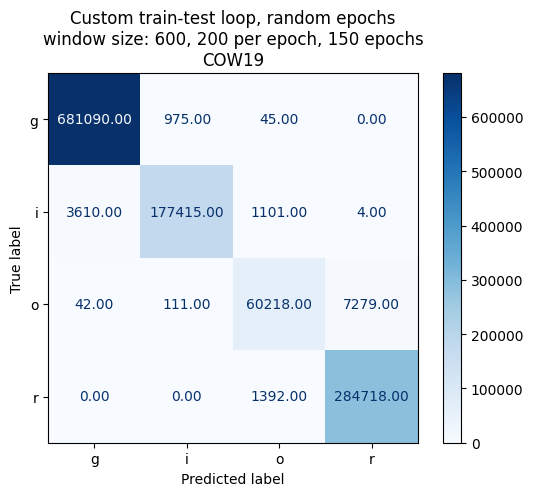

In [ ]:
from tqdm.notebook import tqdm
from custom_model import CowModel
from inference import Inference
from utils import get_frame, get_sequential_frame
from utils import plot_confusion_matrix
import logging

# random.seed(715) # 715 looks good.
random.seed(785)  # 785 makes "other" looks bad, otherwise is good.

all_cm: list[np.ndarray] = []

# NOTE: For loop can be used to implement k-fold cross validation.
# for cow in train_val_cows:
# for c in tqdm(range(len(selected_cows))):

c: int = selected_cows.index("COW19")
# Create a new set of metrics, a new model and a new inference engine for each
# fold iteration.
accumulated_metrics: dict[str, list] = {
    "train_loss": [],
    "train_accuracy": [],
    "val_loss": [],
    "val_accuracy": [],
}
model: tf.keras.Model = CowModel(output_dim=len(existing_types))
engine: Inference = Inference(
    model=model,
    loss_function=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    loss_metric=tf.keras.metrics.Mean(),
    optimizer=tf.keras.optimizers.Adam(),
    accuracy=tf.keras.metrics.SparseCategoricalAccuracy(),
    batch_size=32,
)

# Select cows for training and testing then build datasets.
train_cows: list = list(filter(lambda x: (x != selected_cows[c]), selected_cows))
val_cows: list = list(filter(lambda x: (x == selected_cows[c]), selected_cows))

train_data: pd.DataFrame = pd.concat(
    objs=[folds[i] for i in train_cows],
    ignore_index=True,
    sort=True,
)
val_data: pd.DataFrame = pd.concat(
    objs=[folds[i] for i in val_cows],
    ignore_index=True,
    sort=True,
)

# Train, validate and collect metrics.
for i in tqdm(range(epoch), leave=False):
    # Generate frames for training and testing dataset.
    x_train, y_train = get_frame(
        df=train_data,
        window_size=window_size,
        window_per_epoch=window_per_epoch,
    )
    x_val, y_val = get_frame(
        df=val_data,
        window_size=window_size,
        window_per_epoch=window_per_epoch,
    )
    gc.collect()

    # Create datasets and use them to train the model. Finally, collect metrics.
    train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
    validate_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)
    metrics: dict[str, list] = engine.train_val(
        train_data=train_ds,
        val_data=validate_ds,
        epoch=1,
    )
    accumulated_metrics["train_loss"].extend(metrics["train_loss"])
    accumulated_metrics["train_accuracy"].extend(metrics["train_accuracy"])
    accumulated_metrics["val_loss"].extend(metrics["val_loss"])
    accumulated_metrics["val_accuracy"].extend(metrics["val_accuracy"])

# Test the model with the current fold.
x_test, y_test = get_sequential_frame(
    df=val_data,
    window_size=window_size,
)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
test_result: dict = engine.test(test_data=test_ds)

# Flatten the windows to create the confusion matrix.
data: list = []
labels: list = []

for datum_batch, label_batch in test_ds:
    data.append(datum_batch)
    labels.append(label_batch)

# Process test results and output confusion matrices.
predict_data: np.ndarray = np.concatenate(data)
predict_labels: np.ndarray = np.concatenate(labels)
y_pred: np.ndarray = model.predict(predict_data)
y_test_cm: tf.Tensor = tf.reshape(
    tensor=predict_labels,
    shape=(-1),
)

y_pred_cm: tf.Tensor = (
    tf.math.argmax(
        y_pred,
        axis=2,
        output_type=tf.int64,
    ),
)[0]
y_pred_cm = tf.reshape(
    tensor=y_pred_cm,
    shape=(-1),
)
title: str = "Custom train-test loop, random epochs\nwindow size: {}, {} per epoch, {} epochs\n{}".format(
    window_size,
    window_per_epoch,
    epoch,
    selected_cows[c],
)

cm: np.ndarray = plot_confusion_matrix(
    actual=y_test_cm,
    pred=y_pred_cm,
    unique_numerical_labels=unique_labels,
    display_labels=existing_types,
    normalize="true",
    title=title,
    export="./out/{}/{}_cm.png".format(selected_cows[c].lower(), selected_cows[c]),
)

all_cm.append(cm)

plot_confusion_matrix(
    actual=y_test_cm,
    pred=y_pred_cm,
    unique_numerical_labels=unique_labels,
    display_labels=existing_types,
    normalize=None,
    title=title,
    export="./out/{}/{}_cm_raw.png".format(selected_cows[c].lower(), selected_cows[c]),
)

print("Testing accuracy: {}".format(test_result["test_accuracy"][0]))

gc.collect()

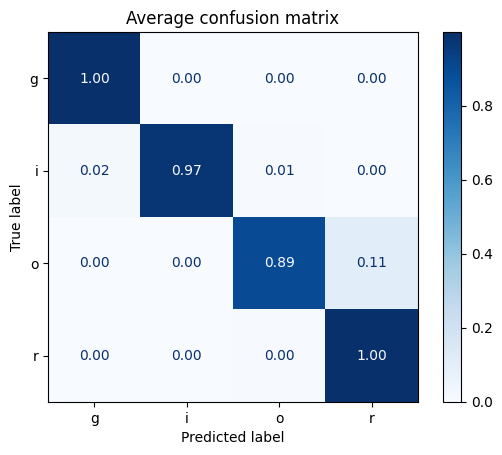

In [ ]:
avg_conf: np.ndarray = np.mean(
    a=all_cm,
    axis=0,
)

fig, ax = plt.subplots()
ax.set_title(label="Average confusion matrix")
cmd = ConfusionMatrixDisplay(avg_conf, display_labels=existing_types)
cmd.plot(cmap=plt.cm.Blues, ax=ax, values_format=".2f")

plt.savefig(
    "./out/avg_cm.png",
    bbox_inches="tight",
)

In [ ]:
model.save("./out/cow_model.keras")